In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
import random
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir='/content/drive/MyDrive/Thesis/data'

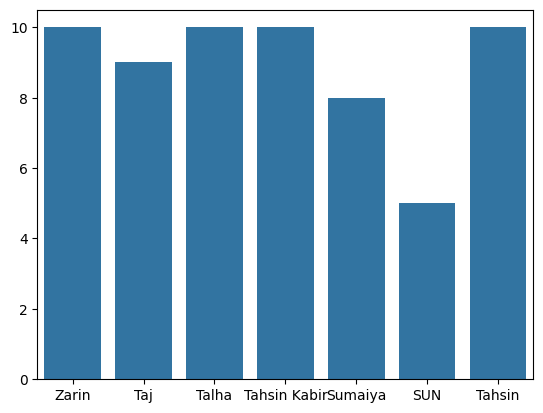

In [ ]:
IMG_SIZE=128
BATCH_SIZE=16
categories = []
class_count = []

train_example = 0
for f in os.listdir(data_dir):
    files = gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][eE][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[jJ][pP][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[pP][nN][gG]')) + \
        gb.glob(str(data_dir + '//' + f + '/*.[hH][eE][iI][cC]'))

    categories.append(f)
    class_count.append(len(files))
    train_example += len(files)

sns.barplot(x=categories, y=class_count)
plt.show()

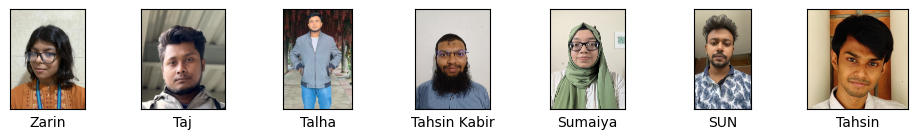

In [ ]:
plt.figure(figsize=(15,4))
i=0
for c in categories:
    path = os.path.join(data_dir,c)
    try:
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            plt.subplot(3,11,i+1)
            plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
            plt.xlabel(c)
            plt.xticks([])
            plt.yticks([])
            i += 1
            break
    except Exception as e:
        pass
plt.tight_layout()
plt.show()

In [ ]:
train_gen = ImageDataGenerator(
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=30,
     # randomly shift images horizontally
    width_shift_range=0.2,
    # randomly shift images vertically
    height_shift_range=0.2,
    # set range for random shear
    shear_range=0.2,
    # set range for random zoom
    zoom_range=0.3,
    # randomly flip images
    horizontal_flip=True,
    # set function that will be applied on each input
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)
train_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)
valid_batches = train_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

Found 51 images belonging to 7 classes.
Found 10 images belonging to 7 classes.


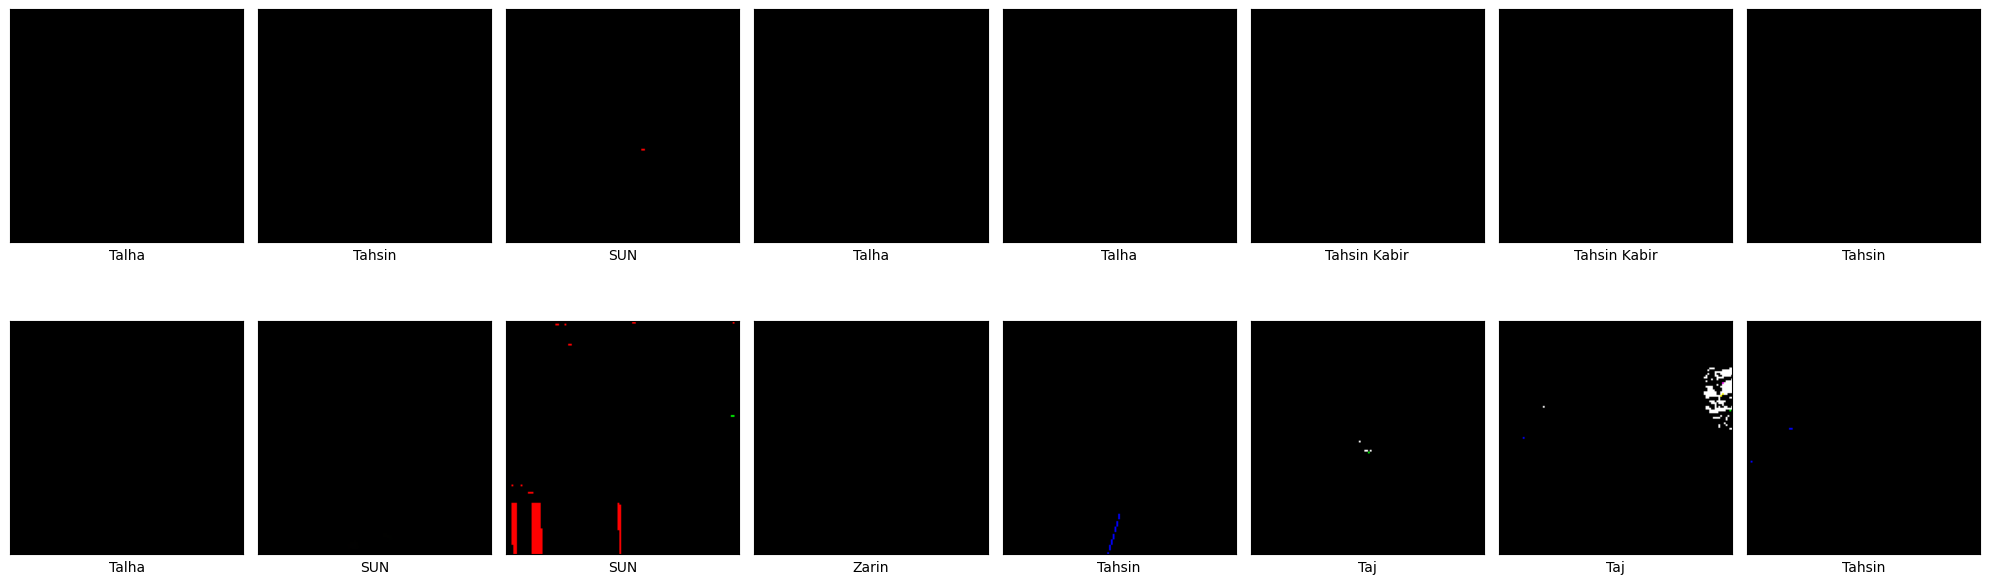

In [ ]:
# display 16 items  for a batch
imgs, labels = next(train_batches)
i = 0
plt.figure(figsize=(20,7))
for img, label in zip(imgs, labels):
    plt.subplot(2,8,i+1)
    plt.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(categories[label.astype('int32')])
    i+=1
    if i == 30:
        break
plt.tight_layout()
plt.show()

In [ ]:
# Define Model using Transfer Learning
input_shape = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)


In [ ]:
# Freeze base model
base_model.trainable = False

In [ ]:
# Custom classifier on top
input_layer = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(input_layer, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output_layer = tf.keras.layers.Dense(len(train_batches.class_indices), activation='softmax')(x)

In [ ]:
# Compile model
model = tf.keras.Model(input_layer, output_layer)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
#callbacks = [
   # EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
   # ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
#]

In [ ]:
# Train the model
history = model.fit(
    train_batches,
    steps_per_epoch=len(train_batches),
    epochs=30,
    validation_data=valid_batches,
    validation_steps=len(valid_batches)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.2268 - loss: 2.1013 - val_accuracy: 0.1000 - val_loss: 2.0058
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 750ms/step - accuracy: 0.2138 - loss: 1.8621 - val_accuracy: 0.3000 - val_loss: 1.7649
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4245 - loss: 1.6812 - val_accuracy: 0.6000 - val_loss: 1.5433
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6255 - loss: 1.4590 - val_accuracy: 0.7000 - val_loss: 1.5363
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 792ms/step - accuracy: 0.6746 - loss: 1.3163 - val_accuracy: 0.8000 - val_loss: 1.3503
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 974ms/step - accuracy: 0.7131 - loss: 1.2414 - val_accuracy: 0.6000 - val_loss: 1.2286
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8821 - loss: 1.0040 - val_accuracy: 0.7000 - val_loss: 1.1426
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - accuracy: 0.7987 - loss: 0.9480 - val_accuracy: 0.8000 - val_loss: 0.9664
Epo

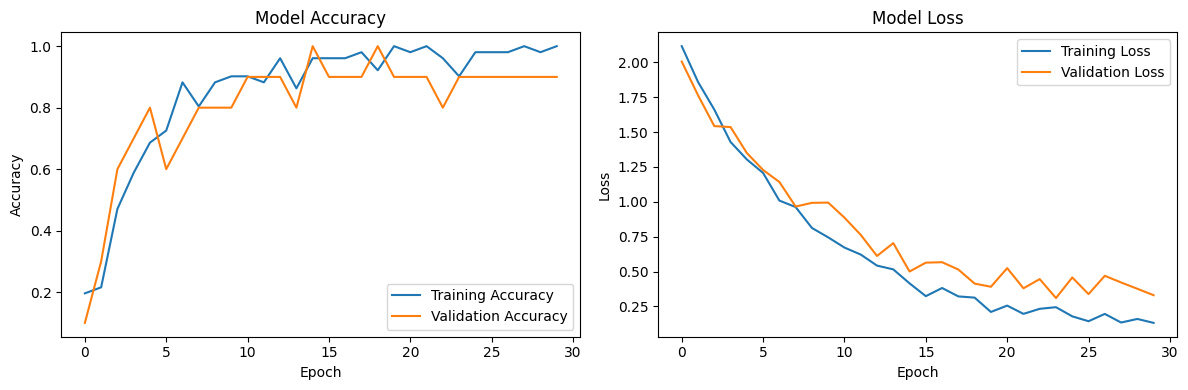

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Computer vission/Dataset/Final_My_Attendance.h5')